# **Data Preparation**

The following part is all about extracting the UCF-50 dataset.



1.   Download dataset and extract files
2.   Split video files into frames
3.   Load a set of frames for each desired class in memory
4.   Encode the labels
5.   Split into training and test set


The code was produced and published by Anwar (Taha Anwar. Introduction to Video Classification and Human Activity Recognition. LearnOpenCV. (March 8, 2021). URL: https://learnopencv.com/introduction-to-video-classification-and-human-activity-recognition/#heading3 last visited: (19.04.2022))



In [ ]:
!wget -nc --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar x UCF50.rar -inul -y

--2022-04-19 03:51:04--  https://www.crcv.ucf.edu/data/UCF50.rar
Resolving www.crcv.ucf.edu (www.crcv.ucf.edu)... 132.170.214.127
Connecting to www.crcv.ucf.edu (www.crcv.ucf.edu)|132.170.214.127|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 3233554570 (3.0G) [application/rar]
Saving to: ‘UCF50.rar’

UCF50.rar           100%[===================>]   3.01G  75.6MB/s    in 42s     

2022-04-19 03:51:46 (73.4 MB/s) - ‘UCF50.rar’ saved [3233554570/3233554570]



In [ ]:
dataset_directory = "UCF50"
classes_list = ["PizzaTossing","PlayingGuitar","PushUps","SalsaSpin"]

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import random

In [ ]:
image_height, image_width = 100,100
max_images_per_class = 4000

In [ ]:
def frames_extraction(video_path):
  frames_list = []
  video_reader = cv2.VideoCapture(video_path)

  while True:
    success, frame = video_reader.read()

    if not success:
      break
    frame = cv2.resize(frame, (image_height, image_width))

    frame = frame / 255

    frames_list.append(frame)
  video_reader.release()
  return frames_list

In [ ]:
def create_dataset():
  temp_features = []
  features = []
  labels = []
  for class_index, class_name in enumerate(classes_list):
    print(f'Extracting Data of Class: {class_name}')

    files_list = os.listdir(os.path.join(dataset_directory, class_name))
    c = 0
    for file_name in files_list:
      if(c>=max_images_per_class):
        break
      video_file_path = os.path.join(dataset_directory, class_name, file_name)
      frames = frames_extraction(video_file_path)
      temp_features.extend(frames)
      c+=1
    features.extend(random.sample(temp_features, max_images_per_class))
    labels.extend([class_index]*max_images_per_class)
    temp_features.clear()
  features = np.asarray(features)
  labels = np.array(labels)
  return features,labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: PizzaTossing
Extracting Data of Class: PlayingGuitar
Extracting Data of Class: PushUps
Extracting Data of Class: SalsaSpin


In [ ]:
one_hot_encoded_labels = keras.utils.to_categorical(labels)

In [ ]:
seed_constant =23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size=0.2, shuffle=True, random_state= seed_constant)

# **Model creation**



1.   Create base model
2.   Freeze layers of base model
3.   Stack layers on top
4.   Train the head layers


The Code is inspired by and recreated from Rosebrock (Adrian Rosebrock. Video classification with Keras and Deep Learning. pyimagesearch. (July 15, 2019). URL: https://pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/ last visited: (19.04.2022))



In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',
    input_tensor=keras.Input(shape=(image_width, image_height,3)),
    include_top = False
)
base_model.trainable = False

headModel = base_model.output
headModel = keras.layers.GlobalAveragePooling2D()(headModel)
headModel = keras.layers.Flatten(name="flatten")(headModel)
headModel = keras.layers.Dense(512, activation="relu")(headModel)
headModel = keras.layers.Dropout(0.5)(headModel)
headModel = keras.layers.Dense(len(classes_list),activation="softmax")(headModel)

model = keras.models.Model(inputs=base_model.input, outputs=headModel)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 49, 49, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                              

In [ ]:
for image in features_train:
  image = keras.preprocessing.image.img_to_array(image)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Epoch 1/20
320/320 [==============================] - 432s 1s/step - loss: 1.3065 - categorical_accuracy: 0.4047 - val_loss: 1.1808 - val_categorical_accuracy: 0.6527
Epoch 2/20
320/320 [==============================] - 426s 1s/step - loss: 1.0798 - categorical_accuracy: 0.5953 - val_loss: 0.9336 - val_categorical_accuracy: 0.7039
Epoch 3/20
320/320 [==============================] - 426s 1s/step - loss: 0.8743 - categorical_accuracy: 0.6896 - val_loss: 0.7783 - val_categorical_accuracy: 0.7211
Epoch 4/20
320/320 [==============================] - 425s 1s/step - loss: 0.7313 - categorical_accuracy: 0.7490 - val_loss: 0.6467 - val_categorical_accuracy: 0.7926
Epoch 5/20
320/320 [==============================] - 424s 1s/step - loss: 0.6331 - categorical_accuracy: 0.7812 - val_loss: 0.5555 - val_categorical_accuracy: 0.8125
Epoch 6/20
320/320 [==============================] - 425s 1s/step - loss: 0.5528 - categorical_accuracy: 0.8158 - val_loss: 0.4937 - val_categorical_accuracy: 0.839

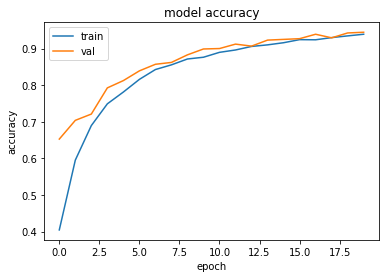

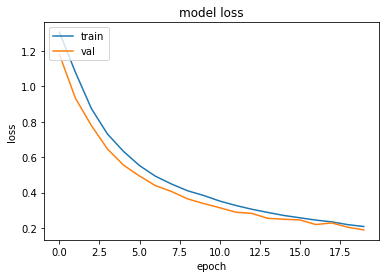

100/100 - 105s - loss: 0.1890 - categorical_accuracy: 0.9488 - 105s/epoch - 1s/step
Test loss: 0.1890098750591278
Test accuracy: 0.9487500190734863


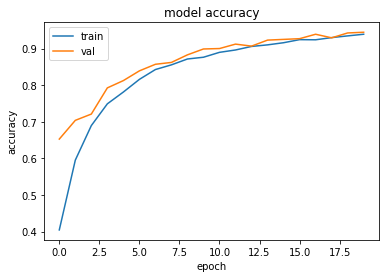

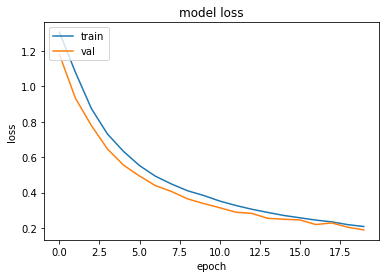

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
model.compile(optimizer=keras.optimizers.Adam(),
                loss = keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=[keras.metrics.CategoricalAccuracy()])
history = model.fit(x=keras.applications.xception.preprocess_input(features_train), y=labels_train, epochs=20, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])


plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

for image in features_test:
  image = keras.preprocessing.image.img_to_array(image)

test_scores = model.evaluate(keras.applications.xception.preprocess_input(features_test), labels_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

#model.save('/content/gdrive/MyDrive/xception_transferLearned_model_smaller')

if not os.path.exists('/content/gdrive/MyDrive/xception_plots'):
  os.mkdir('/content/gdrive/MyDrive/xception_plots')
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/xception_plots/acc.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('/content/gdrive/MyDrive/xception_plots/loss.png') 
plt.show()
